2025-05-20 16:20:57,930 - INFO - Starting eco-driving analysis for file: ts_1747221572.csv
2025-05-20 16:20:57,941 - WARNING - Reached sample cap, stop reading further lines.
2025-05-20 16:20:57,941 - INFO - Parsed 10000 lines from ts_1747221572.csv
2025-05-20 16:20:57,978 - INFO - Parsed data summary: GPS=67, ACC=8452, GYRO=1187, ROT=294
/var/folders/zh/spk217zx6159ls9vspmhgv5m0000gq/T/ipykernel_6829/1346078358.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_df[["distance", "gradient"]].fillna(0, inplace=True)
2025-05-20 16:20:58,019 - INFO - Modeling energy consumption
2025-05-20 16:20:58,026 - INFO - Successfully created combined data with energy modeling: 67 records
2025-05-20 16:20:58,026 - WARNING - Filling missing values in 'gradient' column
2025-05-20 16:20:58,026 - WARNING - Filling 

Processing file: ts_1747221572.csv

DETAILED DATA INSPECTION

==================== GPS DATA ====================
       data_type     timestamp   latitude  longitude   altitude  speed_kmh  \
count       67.0  6.700000e+01  67.000000  67.000000  67.000000  67.000000   
mean         0.0  1.747222e+09  57.687173  11.981958  56.985074  16.893723   
std          0.0  1.948504e+01   0.000479   0.000941   1.356159   9.289508   
min          0.0  1.747222e+09  57.686165  11.980688  53.299999   0.500040   
25%          0.0  1.747222e+09  57.686945  11.981053  56.400002   9.387788   
50%          0.0  1.747222e+09  57.687271  11.982015  57.299999  18.221828   
75%          0.0  1.747222e+09  57.687401  11.982757  57.799999  23.681523   
max          0.0  1.747222e+09  57.687946  11.983512  59.000000  34.712036   

       satellites      speed   speed_ms  
count        67.0  67.000000  67.000000  
mean         12.0   4.692701   4.692701  
std           0.0   2.580419   2.580419  
min          12.

/var/folders/zh/spk217zx6159ls9vspmhgv5m0000gq/T/ipykernel_6829/1346078358.py:724: RuntimeWarning: divide by zero encountered in log10
  np.log10(sample['energy_factor'].values),


Saved main visualization to 'eco_driving_results.png'
Saved control strategies visualization to 'control_strategies.png'


/Applications/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-05-20 16:20:59,060 - INFO - Initialized AdaptiveEcoDrivingController
2025-05-20 16:20:59,061 - INFO - Updating driver profile based on recent data
2025-05-20 16:20:59,064 - INFO - Driver classified as cluster 1 (dynamic)
2025-05-20 16:20:59,064 - INFO - Generating eco-driving recommendations
2025-05-20 16:20:59,070 - INFO - Generated recommendations with expected energy saving: 0.00


Saved driver behavior analysis visualization to 'driver_behavior_analysis.png'
Saved processed data to 'eco_driving_data.csv'
Saved cluster profiles to 'cluster_profiles.txt'
Saved control strategies to 'control_strategies.txt'

Sample Eco-Driving Recommendations:
Driver Cluster: 1
Driver Type: dynamic
Description: Moderate dynamic driving with gentler transitions
Recommended target acceleration: 0.72 m/s²
Recommended speed adjustment: 0.00 m/s
Expected energy saving: 0.00

Eco-Driving Analysis Summary:
  Average Energy Factor: 31302.87
  Energy Factor Range: 0.00 - 123345.49

Driver Behavior Clusters:
  Cluster 0 (dynamic):
    Size: 35 samples
    Average Speed: 158.60 m/s
    Average Acceleration: -0.50 g
    Energy Efficiency: 2.66
  Cluster 1 (dynamic):
    Size: 21 samples
    Average Speed: 218.39 m/s
    Average Acceleration: 0.51 g
    Energy Efficiency: 174.47
  Cluster 2 (dynamic):
    Size: 11 samples
    Average Speed: 87.85 m/s
    Average Acceleration: 0.51 g
    Energy 

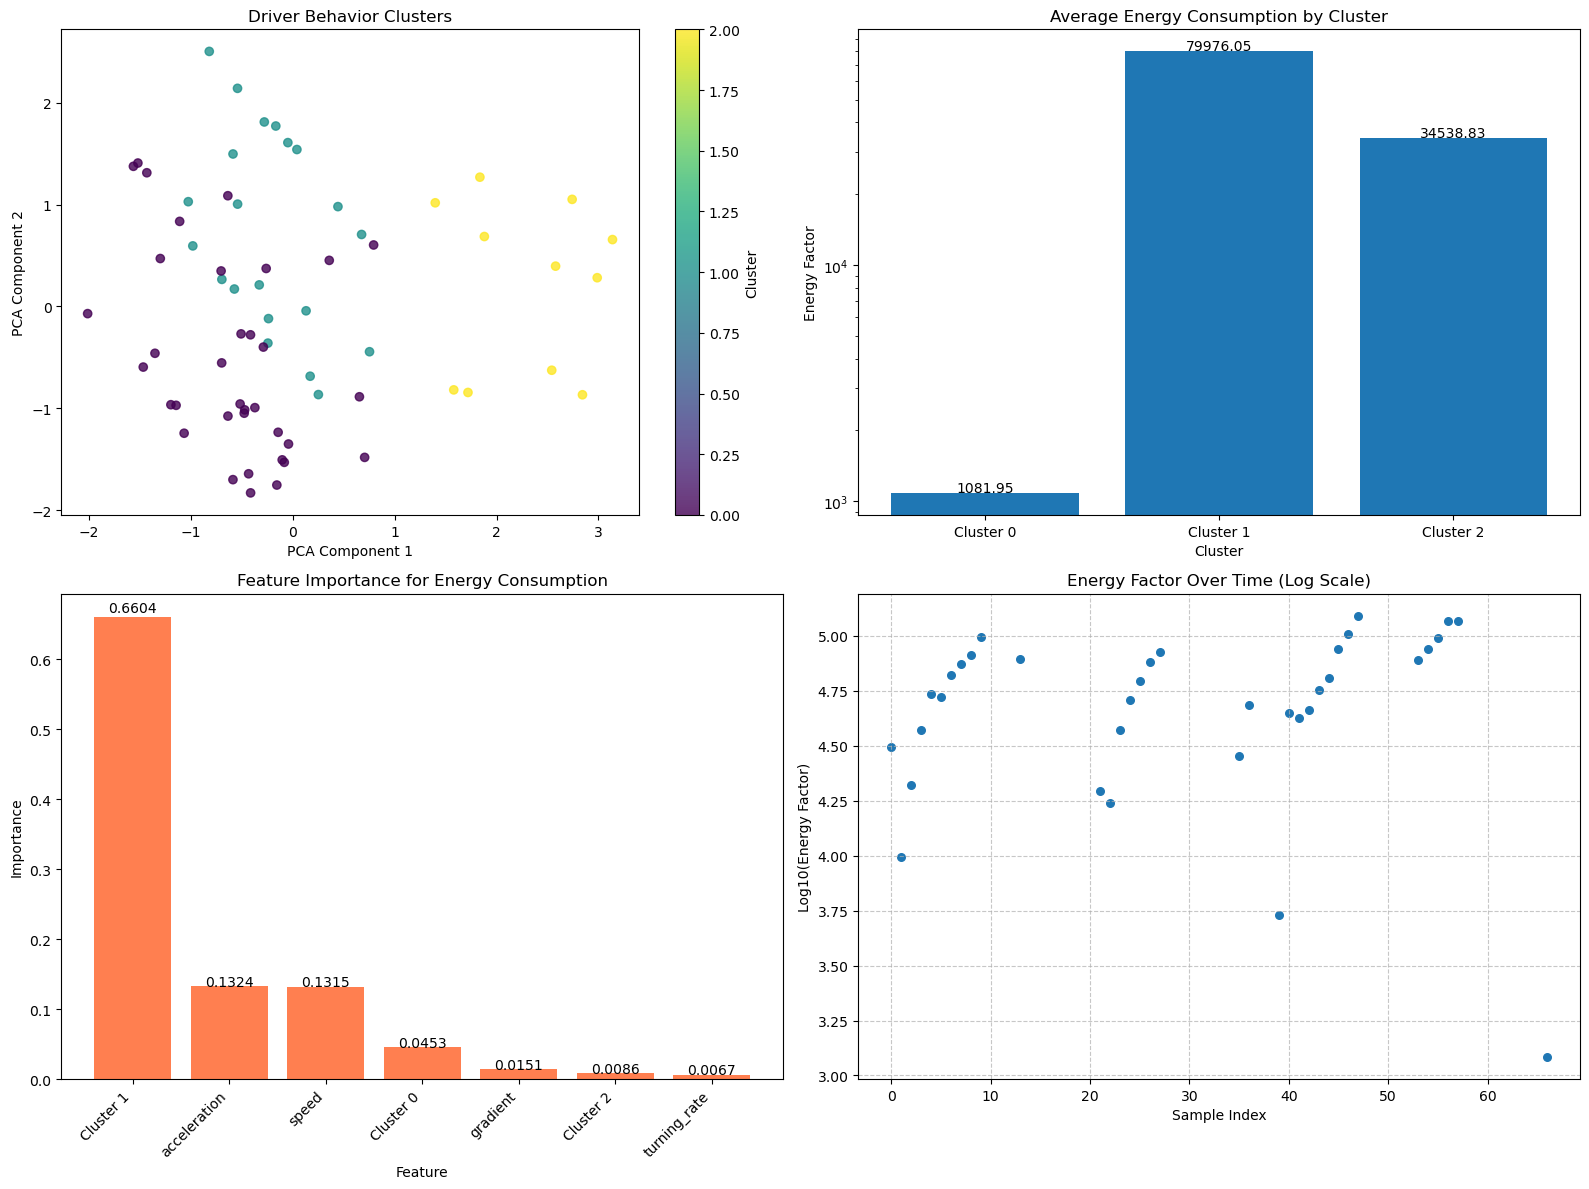

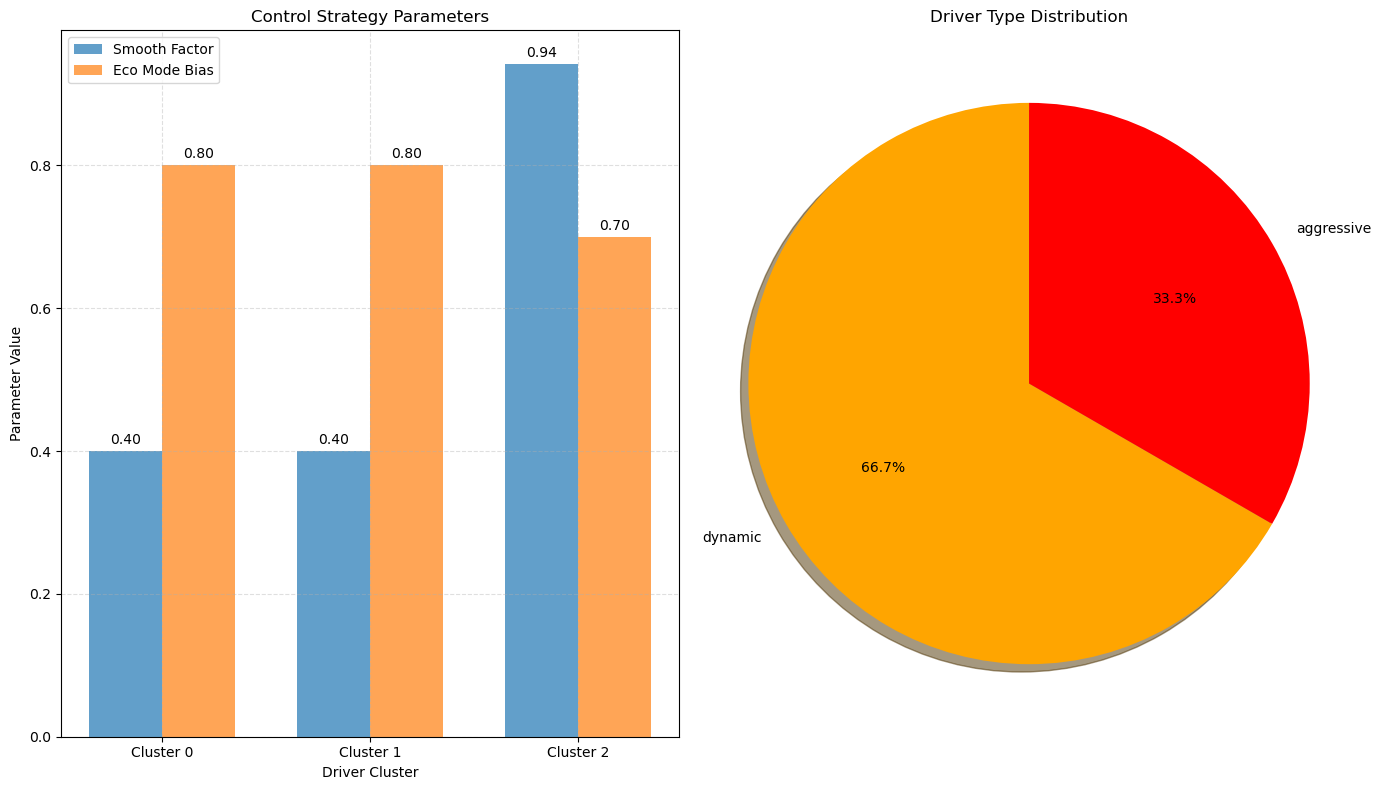

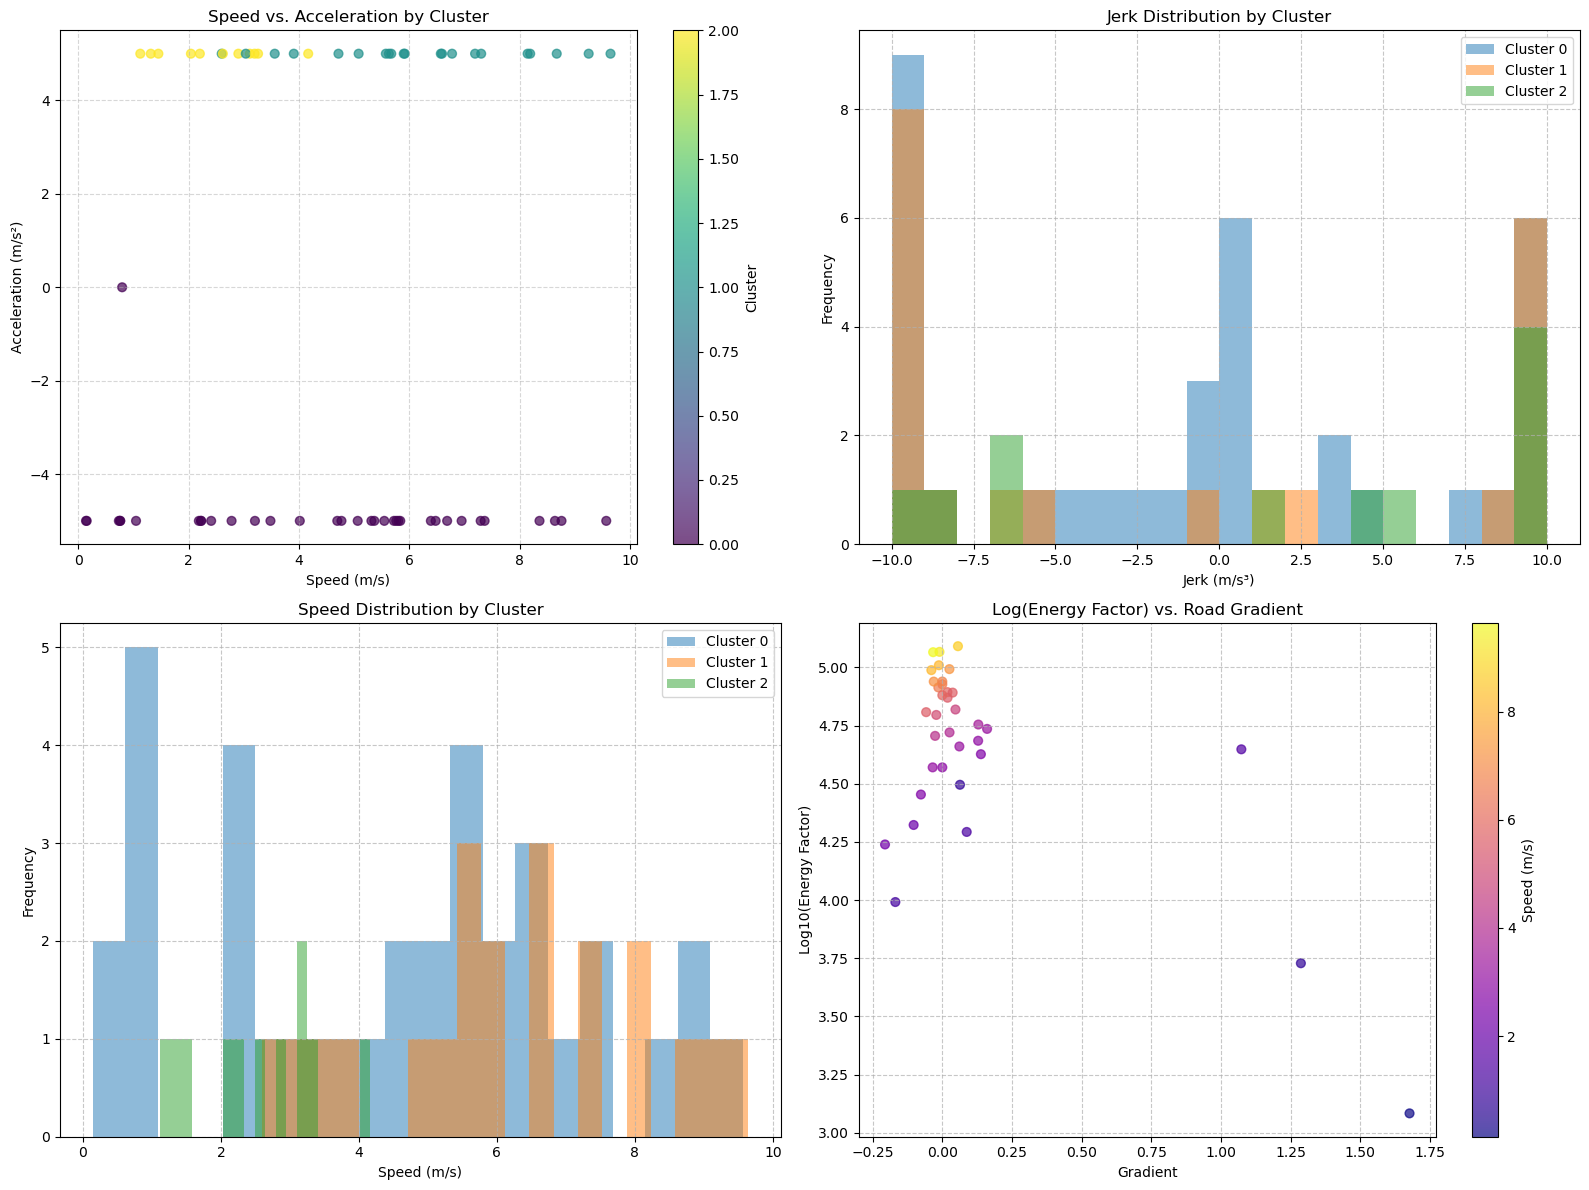

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
from geopy.distance import geodesic
import warnings
import logging

# ───────────────────────────────────────────────
# Logging
# ───────────────────────────────────────────────
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# ───────────────────────────────────────────────
# Constants
# ───────────────────────────────────────────────
GRAVITY = 9.81          # m/s² – 用于 g ↔ m/s² 转换
MAX_TIME_DIFF = 1000    # ms  – GPS/ACC 同步容忍差
MAX_SAMPLES = 10000     # 防止超大文件 OOM

# ═══════════════════════════════════════════════
# 1.  PARSE RAW CSV  → 多数据框
# ═══════════════════════════════════════════════

def parse_data(file_path: str):
    """Parse raw sensor CSV into individual DataFrames.

    中文说明：
    - data_type==0 → GPS 行：字段顺序〈type,timestamp,lat,lon,alt,speed(km/h),sats〉
    - data_type==1 → Accelerometer 行：〈type,timestamp,timestamp_us,x,y,z〉 (m/s²)
    - data_type==2 → Gyro 行：〈...,x,y,z〉  (rad/s)
    - data_type==3 → Rotation-vector 行：〈...,i,j,k,real〉 (unit quaternion)
    
    本函数完成的关键修订：
    - **GPS speed**：读取完即 `speed_kmh`，再生成 `speed` 列为 m/s，供后续所有模块使用。
    - **ACC**：直接保留 m/s²；若想要 g 值则另存 *_g。
    """

    gps_rows, acc_rows, gyro_rows, rot_rows = [], [], [], []
    total_rows = 0

    try:
        with open(file_path, "r") as file:
            for line_num, line in enumerate(file):
                values = line.strip().split(",")
                if len(values) < 2:
                    logger.warning(f"Line {line_num+1}: too few columns → {line}")
                    continue
                try:
                    data_type = int(values[0])
                except ValueError:
                    logger.warning(f"Line {line_num+1}: bad data_type → {values[0]}")
                    continue

                if data_type == 0 and len(values) == 7:
                    gps_rows.append(values)
                elif data_type == 1 and len(values) == 6:
                    acc_rows.append(values)
                elif data_type == 2 and len(values) == 6:
                    gyro_rows.append(values)
                elif data_type == 3 and len(values) == 7:
                    rot_rows.append(values)
                else:
                    logger.warning(f"Line {line_num+1}: unknown/invalid format → {values}")

                total_rows += 1
                if total_rows >= MAX_SAMPLES:
                    logger.warning("Reached sample cap, stop reading further lines.")
                    break
        logger.info(f"Parsed {total_rows} lines from {file_path}")
    except Exception as e:
        logger.error(f"Error reading file: {e}")
        # return empty dfs on failure
        return {k: pd.DataFrame() for k in ("gps", "acc", "gyro", "rot")}

    # ——— 1.1 GPS ————————————————————————————
    gps_df = pd.DataFrame()
    if gps_rows:
        gps_df = pd.DataFrame(gps_rows,
                              columns=["data_type", "timestamp", "latitude", "longitude",
                                       "altitude", "speed_kmh", "satellites"])
        # 类型转换
        gps_df = gps_df.astype({
            "data_type": int,
            "timestamp": int,
            "latitude": float,
            "longitude": float,
            "altitude": float,
            "speed_kmh": float,
            "satellites": int,
        })

        # 一次性单位转换：km/h → m/s
        gps_df["speed"] = gps_df["speed_kmh"] / 3.6   # 后续统一使用 speed (m/s)
        gps_df["speed_ms"] = gps_df["speed"]           # 纯粹冗余，调试友好

        # 坐标合法性检查
        invalid_lat = (~gps_df["latitude"].between(-90, 90)).sum()
        invalid_lon = (~gps_df["longitude"].between(-180, 180)).sum()
        if invalid_lat or invalid_lon:
            logger.warning(f"GPS invalid lat: {invalid_lat}, lon: {invalid_lon}")

        # 极值速度检查用 km/h 判断 (>360 km/h)
        extreme_speed = (gps_df["speed_kmh"] > 360).sum()
        if extreme_speed:
            logger.warning(f"{extreme_speed} GPS points >360 km/h detected")

    # ——— 1.2 Accelerometer ————————————————————
    acc_df = pd.DataFrame()
    if acc_rows:
        acc_df = pd.DataFrame(acc_rows,
                              columns=["data_type", "timestamp", "timestamp_us",
                                       "x", "y", "z"])
        acc_df = acc_df.astype({
            "data_type": int,
            "timestamp": int,
            "timestamp_us": int,
            "x": float,
            "y": float,
            "z": float,
        })

        # m/s² 原样存储
        acc_df["x_ms2"] = acc_df["x"]
        acc_df["y_ms2"] = acc_df["y"]
        acc_df["z_ms2"] = acc_df["z"]
        # 需要 g 单位可另外生成
        acc_df["x_g"] = acc_df["x_ms2"] / GRAVITY
        acc_df["y_g"] = acc_df["y_ms2"] / GRAVITY
        acc_df["z_g"] = acc_df["z_ms2"] / GRAVITY

        # 极值检查 (>50 m/s² ≈5 g)
        extreme_acc = ((acc_df[["x_ms2", "y_ms2", "z_ms2"]].abs() > 50).any(axis=1)).sum()
        if extreme_acc:
            logger.warning(f"{extreme_acc} accelerometer points >50 m/s² detected")

    # ——— 1.3 Gyroscope ——————————————————————
    gyro_df = pd.DataFrame()
    if gyro_rows:
        gyro_df = pd.DataFrame(gyro_rows,
                               columns=["data_type", "timestamp", "timestamp_us",
                                        "x", "y", "z"])
        gyro_df = gyro_df.astype({
            "data_type": int,
            "timestamp": int,
            "timestamp_us": int,
            "x": float,
            "y": float,
            "z": float,
        })
        extreme_gyro = ((gyro_df[["x", "y", "z"]].abs() > 20).any(axis=1)).sum()
        if extreme_gyro:
            logger.warning(f"{extreme_gyro} gyro points >20 rad/s detected")

    # ——— 1.4 Rotation vector ————————————————
    rot_df = pd.DataFrame()
    if rot_rows:
        rot_df = pd.DataFrame(rot_rows,
                              columns=["data_type", "timestamp", "timestamp_us",
                                       "i", "j", "k", "real"])
        rot_df = rot_df.astype({
            "data_type": int,
            "timestamp": int,
            "timestamp_us": int,
            "i": float,
            "j": float,
            "k": float,
            "real": float,
        })
        invalid_quat = (~rot_df[["i", "j", "k", "real"]].abs().le(1)).any(axis=1).sum()
        if invalid_quat:
            logger.warning(f"{invalid_quat} quaternion rows out of [-1,1] range")

    logger.info("Parsed data summary: "
                f"GPS={len(gps_df)}, ACC={len(acc_df)}, "
                f"GYRO={len(gyro_df)}, ROT={len(rot_df)}")

    return {"gps": gps_df, "acc": acc_df, "gyro": gyro_df, "rot": rot_df}

# ═══════════════════════════════════════════════
# 2.  DATA QUALITY CHECK (unchanged)
# ═══════════════════════════════════════════════
# ... 下面函数大体保持，但注释会简写以节省篇幅 ...

def check_missing_values(data_dict):
    """打印缺失值 & 基本统计，帮助调试。"""
    sep = "=" * 50
    print(f"\n{sep}\nDETAILED DATA INSPECTION\n{sep}")
    for name, df in data_dict.items():
        print(f"\n{'='*20} {name.upper()} DATA {'='*20}")
        if df.empty:
            print("None")
            continue
        print(df.describe(include='all'))
    print(f"\n{sep}\nEND OF INSPECTION\n{sep}")

# ═══════════════════════════════════════════════
# 3.  FEATURE EXTRACTION  (仅改单位注释)
# ═══════════════════════════════════════════════

def extract_features(data_dict):
    """Generate route / behavior / turning features."""
    features = {}
    # — GPS route features —
    if not data_dict["gps"].empty:
        gps_df = data_dict["gps"].copy()
        dist, grad = [], []
        for i in range(1, len(gps_df)):
            p1 = (gps_df["latitude"].iat[i-1], gps_df["longitude"].iat[i-1])
            p2 = (gps_df["latitude"].iat[i],   gps_df["longitude"].iat[i])
            try:
                d = geodesic(p1, p2).meters
            except Exception:
                d = 0
            dist.append(d)
            grad.append((gps_df["altitude"].iat[i] - gps_df["altitude"].iat[i-1]) / d if d else 0)
        gps_df.loc[1:, "distance"] = dist
        gps_df.loc[1:, "gradient"] = grad
        gps_df[["distance", "gradient"]].fillna(0, inplace=True)
        # acceleration from speed diff
        dt = gps_df["timestamp"].diff().fillna(1) / 1000
        gps_df["time_diff"] = dt
        gps_df["speed_change"] = gps_df["speed"].diff().fillna(0)
        gps_df["acceleration"] = np.where(dt > 0, gps_df["speed_change"] / dt, 0)
        gps_df["acceleration"] = gps_df["acceleration"].clip(-10, 10)
        features["route"] = gps_df
    # — ACC behavior features —
    if not data_dict["acc"].empty:
        acc_df = data_dict["acc"].copy()
        acc_df["magnitude"] = np.linalg.norm(acc_df[["x_ms2", "y_ms2", "z_ms2"]].values, axis=1)
        dt = acc_df["timestamp"].diff().fillna(1) / 1000
        acc_df["jerk"] = np.where(dt > 0, acc_df["magnitude"].diff().fillna(0) / dt, 0)
        # Savitzky‑Golay 滤波
        if len(acc_df) > 5:
            win = min(21, len(acc_df)//2*2+1)
            acc_df["jerk_smooth"] = savgol_filter(acc_df["jerk"], win, 3)
        else:
            acc_df["jerk_smooth"] = acc_df["jerk"]

        acc_df["jerk_smooth"] = acc_df["jerk_smooth"].clip(-10, 10)

        features["behavior"] = acc_df
    # — GYRO turning —
    if not data_dict["gyro"].empty:
        gyro_df = data_dict["gyro"].copy()
        gyro_df["turning_rate"] = gyro_df["z"].abs()
        features["turning"] = gyro_df
    return features

def model_energy_consumption(features):
    """
    Model energy consumption based on route and behavior features.
    基于路线和行为特征建模能量消耗。
    
    Args:
        features: Dictionary of feature dataframes
        
    Returns:
        Combined dataframe with energy consumption estimates
    """
    logger.info("Modeling energy consumption")
    
    if 'route' in features and 'behavior' in features:
        try:
            # Get timestamps for synchronization
            route_times = features['route']['timestamp'].values
            behavior_times = features['behavior']['timestamp'].values
            
            combined_data = []
            sync_errors = 0
            
            # Combine GPS and accelerometer data by timestamp
            for i, row in features['route'].iterrows():
                gps_time = row['timestamp']
                
                # Find closest accelerometer data by timestamp
                time_diffs = np.abs(behavior_times - gps_time)
                closest_acc_idx = np.argmin(time_diffs)
                
                # Check if the closest data point is within acceptable time difference
                min_time_diff = time_diffs[closest_acc_idx]
                if min_time_diff > MAX_TIME_DIFF:
                    sync_errors += 1
                    continue
                
                # Combine data
                entry = {
                    'timestamp': gps_time,
                    'speed': row['speed'],
                    'acceleration': row['acceleration'],
                    'gradient': row['gradient'],
                    'acc_x': features['behavior']['x_ms2'].iloc[closest_acc_idx],
                    'acc_y': features['behavior']['y_ms2'].iloc[closest_acc_idx],
                    'acc_z': features['behavior']['z_ms2'].iloc[closest_acc_idx],
                    'jerk': features['behavior']['jerk_smooth'].iloc[closest_acc_idx]
                }
                
                # Add turning rate if available
                if 'turning' in features:
                    turning_times = features['turning']['timestamp'].values
                    closest_turn_idx = np.argmin(np.abs(turning_times - gps_time))
                    turn_time_diff = np.abs(turning_times[closest_turn_idx] - gps_time)
                    
                    if turn_time_diff <= MAX_TIME_DIFF:
                        entry['turning_rate'] = features['turning']['turning_rate'].iloc[closest_turn_idx]
                    else:
                        entry['turning_rate'] = 0
                else:
                    entry['turning_rate'] = 0
                    
                combined_data.append(entry)
            
            if sync_errors > 0:
                logger.warning(f"Skipped {sync_errors} points due to synchronization errors (time diff > {MAX_TIME_DIFF}ms)")
            
            # Create combined dataframe
            combined_df = pd.DataFrame(combined_data)
            
            combined_df['acceleration'] = combined_df['acceleration'].clip(-5, 5)   # ±5 m/s² ≈ ±0.5 g
            combined_df['jerk']         = combined_df['jerk'].clip(-10, 10)

            if not combined_df.empty:
                # Calculate energy factors
                combined_df['energy_factor'] = calculate_energy_factors(combined_df)
                logger.info(f"Successfully created combined data with energy modeling: {len(combined_df)} records")
                return combined_df
            else:
                logger.warning("No synchronized data points found between GPS and accelerometer data")
                return pd.DataFrame()
        except Exception as e:
            logger.error(f"Error in energy consumption modeling: {e}")
            return pd.DataFrame()
    else:
        missing = []
        if 'route' not in features:
            missing.append('route')
        if 'behavior' not in features:
            missing.append('behavior')
        logger.warning(f"Cannot model energy consumption: missing required feature types: {', '.join(missing)}")
        return pd.DataFrame()

def calculate_energy_factors(df):
    """
    Return traction power (W)  **always ≥0**  and
    attach per-segment energy (J) into df['energy_J'].
    """
    try:
        # ─── 车辆参数 ───
        mass = 2500        # kg
        g    = 9.81        # m/s²
        rho  = 1.225       # kg/m³
        Cd   = 0.319
        A    = 2.54        # m²
        Cr   = 0.013

        power_W = np.zeros(len(df))

        for i in range(len(df)):
            v = max(0.1, df['speed'].iloc[i])                 # m/s
            θ = np.arctan(df['gradient'].iloc[i])             # rad

            F_roll = Cr * mass * g * np.cos(θ)
            F_aero = 0.5 * rho * Cd * A * v**2
            F_grad = mass * g * np.sin(θ)
            F_acc  = mass * df['acceleration'].iloc[i]

            F_total = F_roll + F_aero + F_grad + F_acc
            F_traction = max(F_total, 0)                      # 制动/回收不算牵引能耗

            power_W[i] = F_traction * v

        # 保存功率
        df['power_W'] = power_W

        # 计算每两个样点的能量 (J) 方便后续做累加 / kWh
        dt = df['timestamp'].diff().fillna(0) / 1000.0        # s
        df['energy_J'] = power_W * dt.values

        return power_W

    except Exception as e:
        logger.error(f"Error calculating energy factors: {e}")
        return np.zeros(len(df))


def cluster_driving_behaviors(combined_data, n_clusters: int = 3):
    """
    Cluster driving behaviour and build statistical profiles.

    Returns
    -------
    clustered_data : DataFrame  追加 driver_cluster 列
    cluster_profiles : dict     每簇统计值（含 kWh/100 km）
    X_pca : ndarray[shape=(N,2)]  用于可视化
    clusters : ndarray[int]      聚类标签
    """
    logger.info(f"Clustering driving behaviours into {n_clusters} groups")

    # ──────────────────────────────────────────
    # 0. 必要列检查
    # ──────────────────────────────────────────
    required = ['speed', 'acceleration', 'jerk', 'turning_rate', 'energy_J']
    for col in required:
        if col not in combined_data.columns:
            logger.warning(f"Missing column '{col}', filling 0.")
            combined_data[col] = 0.0

    # ──────────────────────────────────────────
    # 1. 剪裁极端加速度 / jerk
    # ──────────────────────────────────────────
    combined_data['acceleration'] = combined_data['acceleration'].clip(-5, 5)   # ±0.5 g
    combined_data['jerk']         = combined_data['jerk'].clip(-10, 10)

    # ──────────────────────────────────────────
    # 2. 特征标准化 → K-Means
    # ──────────────────────────────────────────
    feats = ['speed', 'acceleration', 'jerk', 'turning_rate']
    X = combined_data[feats].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    # PCA for plotting
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
    except Exception as e:
        logger.warning(f"PCA failed: {e}; using first two dims")
        X_pca = X_scaled[:, :2]

    # 聚类数不能超过 N-1
    n_clusters = min(n_clusters, max(1, len(X) - 1))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    combined_data['driver_cluster'] = clusters

    # ──────────────────────────────────────────
    # 3. 统计 profile（kWh / 100 km）
    # ──────────────────────────────────────────
    cluster_profiles = {}
    for cid in range(n_clusters):
        data_c = combined_data[combined_data['driver_cluster'] == cid]
        if data_c.empty:
            cluster_profiles[cid] = {'size': 0, 'driver_type': 'unknown'}
            continue

        # 距离 km ≈ Σ(speed * dt)
        dt = data_c['timestamp'].diff().fillna(0) / 1000.0        # s
        dist_km = (data_c['speed'] * dt).sum() / 1000.0

        # 牵引能量 kWh
        energy_kWh = data_c['energy_J'].sum() / 3.6e6

        energy_eff = energy_kWh / dist_km * 100 if dist_km > 0 else 0.0

        profile = {
            'size': len(data_c),
            'avg_speed': data_c['speed'].mean(),
            'std_speed': data_c['speed'].std(),
            'avg_acceleration': data_c['acceleration'].mean(),
            'std_acceleration': data_c['acceleration'].std(),
            'avg_jerk': data_c['jerk'].mean(),
            'std_jerk': data_c['jerk'].std(),
            'avg_turning_rate': data_c['turning_rate'].mean(),
            'std_turning_rate': data_c['turning_rate'].std(),
            'energy_efficiency': energy_eff,          # kWh / 100 km
        }

        # driver_type 依据平滑 jerk & 加速度阈值
        if profile['avg_jerk'] > 2:
            profile['driver_type'] = 'aggressive'
        elif abs(profile['avg_acceleration']) > 3:     # ≈0.3 g
            profile['driver_type'] = 'dynamic'
        elif profile['avg_turning_rate'] > 0.3:
            profile['driver_type'] = 'cornering'
        else:
            profile['driver_type'] = 'efficient'

        cluster_profiles[cid] = profile

    logger.info(f"Created {n_clusters} driver clusters.")
    return combined_data, cluster_profiles, X_pca, clusters


def develop_control_strategy(combined_data, cluster_profiles):
    """
    Develop adaptive control strategies based on driver clusters
    基于驾驶员聚类开发自适应控制策略
    
    Args:
        combined_data: Dataframe with combined sensor data and features
        cluster_profiles: Dictionary with statistical profiles for each cluster
        
    Returns:
        Tuple of (model, feature_importance, control_strategies, feature_names)
    """
    logger.info("Developing control strategies based on driver clusters")
    
    # Essential features for strategy development
    features = ['speed', 'acceleration', 'gradient', 'turning_rate', 'driver_cluster']
    
    # Ensure all required features exist
    for feature in features:
        if feature not in combined_data.columns:
            logger.warning(f"Feature '{feature}' not found in data. Adding with default value.")
            if feature == 'driver_cluster':
                combined_data[feature] = 0
            else:
                combined_data[feature] = 0.0
    
    # Ensure energy factor exists
    if 'energy_factor' not in combined_data.columns:
        logger.warning("'energy_factor' column not found. Adding with default values.")
        combined_data['energy_factor'] = 10.0
    
    # Handle missing values
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            logger.warning(f"Filling missing values in '{col}' column")
            if col == 'driver_cluster':
                combined_data[col] = combined_data[col].fillna(0).astype(int)
            else:
                mean_val = combined_data[col].mean() if combined_data[col].notna().any() else 0.0
                combined_data[col] = combined_data[col].fillna(mean_val)
    
    # Create feature matrix with one-hot encoded clusters
    X = pd.get_dummies(combined_data[features], columns=['driver_cluster'])
    y = combined_data['energy_factor']
    
    # Store feature names for later prediction
    feature_names = list(X.columns)
    
    # Train random forest model
    try:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
        # Extract feature importance
        feature_importance = dict(zip(X.columns, model.feature_importances_))
        
        # Generate control strategies for each cluster
        control_strategies = {}
        
        for cluster, profile in cluster_profiles.items():
            # Extract relevant metrics
            avg_jerk = profile.get('avg_jerk', 0.0)
            avg_acceleration = profile.get('avg_acceleration', 0.0)
            avg_turning_rate = profile.get('avg_turning_rate', 0.0)
            avg_speed = profile.get('avg_speed', 30.0)
            driver_type = profile.get('driver_type', 'default')
            
            # Tailored strategy based on driver behavior pattern
            if driver_type == 'aggressive' or avg_jerk > 0.5:
                strategy = {
                    'driver_type': 'aggressive',
                    'acceleration_smoothing': True,
                    'smooth_factor': min(1.0, avg_jerk / 2) if avg_jerk > 0 else 0.5,
                    'anticipation_distance': 100 + (avg_speed * 5),
                    'eco_mode_bias': 0.7,
                    'description': 'Smooth out aggressive acceleration and deceleration'
                }
            elif driver_type == 'dynamic' or avg_acceleration > 1.0:
                strategy = {
                    'driver_type': 'dynamic',
                    'acceleration_smoothing': True,
                    'smooth_factor': 0.4,
                    'anticipation_distance': 80 + (avg_speed * 3),
                    'eco_mode_bias': 0.8,
                    'description': 'Moderate dynamic driving with gentler transitions'
                }
            elif driver_type == 'cornering' or avg_turning_rate > 0.3:
                strategy = {
                    'driver_type': 'cornering',
                    'acceleration_smoothing': False,
                    'smooth_factor': 0.2,
                    'anticipation_distance': 120 + (avg_speed * 4),
                    'eco_mode_bias': 0.5,
                    'description': 'Optimize for cornering with better anticipation'
                }
            else:
                strategy = {
                    'driver_type': 'efficient',
                    'acceleration_smoothing': False,
                    'smooth_factor': 0.1,
                    'anticipation_distance': 60 + (avg_speed * 2),
                    'eco_mode_bias': 0.3,
                    'description': 'Maintain already efficient driving style'
                }
            
            control_strategies[cluster] = strategy
        
        logger.info(f"Successfully developed control strategies for {len(control_strategies)} driver clusters")
        return model, feature_importance, control_strategies, feature_names
    
    except Exception as e:
        logger.error(f"Error developing control strategies: {e}")
        
        # Return fallback default strategy
        default_strategy = {
            0: {
                'driver_type': 'default',
                'acceleration_smoothing': True,
                'smooth_factor': 0.3,
                'anticipation_distance': 80,
                'eco_mode_bias': 0.5,
                'description': 'Default balanced strategy'
            }
        }
        
        # Create dummy model and feature importance
        dummy_model = RandomForestRegressor(n_estimators=10, random_state=42)
        dummy_X = np.zeros((len(combined_data), 1))
        dummy_y = combined_data['energy_factor'] if 'energy_factor' in combined_data.columns else np.zeros(len(combined_data))
        dummy_model.fit(dummy_X, dummy_y)
        
        dummy_importance = {'fallback_feature': 1.0}
        
        return dummy_model, dummy_importance, default_strategy, ['fallback_feature']

def visualize_results(results):
    """
    Visualize the results of the eco-driving analysis with simplified plots.
    使用简化图表可视化节能驾驶分析结果。
    
    Args:
        results: Dictionary with analysis results
    """
    if isinstance(results, str):
        print(f"Cannot visualize results: {results}")
        return
    
    print("\nVisualization diagnostics:")
    print(f"Energy factor range: {results['data']['energy_factor'].min()} - {results['data']['energy_factor'].max()}")
    if 'feature_importance' in results:
        print("Top 5 feature importance values:")
        for feature, importance in sorted(results['feature_importance'].items(), 
                                         key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {feature}: {importance:.6f}")
    
    # 创建非常简单的可视化来确保至少显示内容
    plt.figure(figsize=(16, 12))

    # 1. 左上：聚类散点图
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(results['pca_data'][:, 0], results['pca_data'][:, 1], 
                         c=results['clusters'], cmap='viridis', alpha=0.8)
    plt.title('Driver Behavior Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')

    # 2. 右上：每个集群的平均能量消耗
    plt.subplot(2, 2, 2)
    energy_by_cluster = results['data'].groupby('driver_cluster')['energy_factor'].mean()
    plt.bar(range(len(energy_by_cluster)), energy_by_cluster.values)

    plt.yscale('log') 
    plt.title('Average Energy Consumption by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Energy Factor')
    plt.xticks(range(len(energy_by_cluster)), [f'Cluster {i}' for i in energy_by_cluster.index])
    
    # 为每个条形添加数值标签
    for i, v in enumerate(energy_by_cluster.values):
        plt.text(i, v + v*0.01, f"{v:.2f}", ha='center')

    # 3. 左下：特征重要性简单条形图
    plt.subplot(2, 2, 3)
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        # 只选择重要性大于0.001的特征，避免显示接近零的特征
        filtered_importance = {k: v for k, v in results['feature_importance'].items() if v > 0.001}
        
        if filtered_importance:
            # 转换为排序列表
            sorted_features = sorted(filtered_importance.items(), key=lambda x: x[1], reverse=True)
            features = [item[0] for item in sorted_features]
            importances = [item[1] for item in sorted_features]
            
            # 限制显示的特征数量
            max_features = min(10, len(features))
            features = features[:max_features]
            importances = importances[:max_features]
            
            # 绘制条形图
            plt.bar(range(len(features)), importances, color='coral')
            plt.title('Feature Importance for Energy Consumption')
            plt.xlabel('Feature')
            plt.ylabel('Importance')
            
            # 使特征名称更可读
            readable_features = []
            for f in features:
                if 'driver_cluster' in f:
                    readable_features.append(f.replace('driver_cluster_', 'Cluster '))
                else:
                    readable_features.append(f)
                    
            plt.xticks(range(len(features)), readable_features, rotation=45, ha='right')
            
            # 为每个条形添加数值标签
            for i, v in enumerate(importances):
                plt.text(i, v + v*0.01, f"{v:.4f}", ha='center')
        else:
            plt.text(0.5, 0.5, 'No significant feature importance values', 
                    horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.5, 0.5, 'No feature importance data available', 
                horizontalalignment='center', verticalalignment='center')

    plt.subplot(2, 2, 4)
    try:
        if len(results['data']) > 1000:
            sample_size = min(1000, len(results['data']))
            sample = results['data'].sample(sample_size).sort_values('timestamp')
        else:
            sample = results['data'].sort_values('timestamp')
            
        if sample['energy_factor'].max() > 1000:
                plt.scatter(range(len(sample)),
                np.log10(sample['energy_factor'].values),
                s=30)                     # s=点大小
                plt.title('Energy Factor Over Time (Log Scale)')
                plt.ylabel('Log10(Energy Factor)')
        else:
                plt.scatter(range(len(sample)),
                sample['energy_factor'].values,
                s=30)
                plt.title('Energy Factor Over Time')
                plt.ylabel('Energy Factor')
            
        plt.xlabel('Sample Index')
        plt.grid(True, linestyle='--', alpha=0.7)
    except Exception as e:
        plt.text(0.5, 0.5, f'Error plotting energy time series: {str(e)}',
                horizontalalignment='center', verticalalignment='center')
        print(f"Error plotting energy time series: {e}")

    plt.tight_layout()
    plt.savefig('eco_driving_results.png')
    print("Saved main visualization to 'eco_driving_results.png'")
    
    plt.figure(figsize=(14, 8))
    strategies = results['control_strategies']
    
    if strategies and len(strategies) > 0:
        plt.subplot(1, 2, 1)
        try:
            clusters = list(strategies.keys())
            cluster_labels = [f'Cluster {c}' for c in clusters]
            
            metrics = ['smooth_factor', 'eco_mode_bias']
            metric_names = ['Smooth Factor', 'Eco Mode Bias']
            
            bar_width = 0.35
            index = np.arange(len(clusters))
            
            for i, (metric, name) in enumerate(zip(metrics, metric_names)):
                values = []
                for c in clusters:
                    values.append(strategies[c].get(metric, 0))
                
                plt.bar(index + i*bar_width, values, bar_width, 
                        label=name, alpha=0.7)
                
                # 添加数值标签
                for j, v in enumerate(values):
                    plt.text(j + i*bar_width, v + 0.01, f"{v:.2f}", ha='center')
            
            plt.xlabel('Driver Cluster')
            plt.ylabel('Parameter Value')
            plt.title('Control Strategy Parameters')
            plt.xticks(index + bar_width/2, cluster_labels)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.4)
            
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting control metrics: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting control metrics: {e}")
        
        # 2. 右：驾驶员类型饼图
        plt.subplot(1, 2, 2)
        try:
            # 提取驾驶员类型
            driver_types = []
            for c in clusters:
                driver_types.append(strategies[c].get('driver_type', 'unknown'))
                
            # 统计每种类型的数量
            driver_type_counts = {}
            for dtype in driver_types:
                if dtype in driver_type_counts:
                    driver_type_counts[dtype] += 1
                else:
                    driver_type_counts[dtype] = 1
                    
            labels = list(driver_type_counts.keys())
            sizes = list(driver_type_counts.values())
            
            # 为不同的驾驶员类型定义颜色
            colors = {
                'aggressive': 'red',
                'dynamic': 'orange',
                'cornering': 'purple',
                'efficient': 'green',
                'unknown': 'gray'
            }
            
            # 获取饼图的颜色
            pie_colors = [colors.get(dtype, 'blue') for dtype in labels]
            
            plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%',
                    startangle=90, shadow=True)
            plt.axis('equal')  # 确保饼图是圆形的
            plt.title('Driver Type Distribution')
            
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting driver types: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting driver types: {e}")
    else:
        plt.text(0.5, 0.5, 'No control strategy data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('control_strategies.png')
    print("Saved control strategies visualization to 'control_strategies.png'")
    
    # 创建驾驶行为分析图
    plt.figure(figsize=(16, 12))
    
    if not results['data'].empty:
        # 1. 速度与加速度散点图
        plt.subplot(2, 2, 1)
        try:
            if 'speed' in results['data'].columns and 'acceleration' in results['data'].columns:
                scatter = plt.scatter(results['data']['speed'], results['data']['acceleration'], 
                                    c=results['data']['driver_cluster'], cmap='viridis', 
                                    alpha=0.7, s=40)
                plt.title('Speed vs. Acceleration by Cluster')
                plt.xlabel('Speed (m/s)')
                plt.ylabel('Acceleration (m/s²)')
                plt.colorbar(scatter, label='Cluster')
                plt.grid(True, linestyle='--', alpha=0.5)
            else:
                plt.text(0.5, 0.5, 'Speed or acceleration data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting speed vs acceleration: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting speed vs acceleration: {e}")
        
        # 2. 加加速度分布直方图
        plt.subplot(2, 2, 2)
        try:
            if 'jerk' in results['data'].columns:
                for cluster in range(len(results['cluster_profiles'])):
                    cluster_data = results['data'][results['data']['driver_cluster'] == cluster]
                    if not cluster_data.empty:
                        plt.hist(cluster_data['jerk'], bins=20, alpha=0.5, 
                                label=f'Cluster {cluster}')
                
                plt.title('Jerk Distribution by Cluster')
                plt.xlabel('Jerk (m/s³)')
                plt.ylabel('Frequency')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Jerk data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting jerk distribution: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting jerk distribution: {e}")
        
        # 3. 速度分布直方图
        plt.subplot(2, 2, 3)
        try:
            if 'speed' in results['data'].columns:
                for cluster in range(len(results['cluster_profiles'])):
                    cluster_data = results['data'][results['data']['driver_cluster'] == cluster]
                    if not cluster_data.empty:
                        plt.hist(cluster_data['speed'], bins=20, alpha=0.5,
                                label=f'Cluster {cluster}')
                
                plt.title('Speed Distribution by Cluster')
                plt.xlabel('Speed (m/s)')
                plt.ylabel('Frequency')
                plt.legend()
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Speed data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting speed distribution: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting speed distribution: {e}")
        
        # 4. 能量因子与坡度散点图
        plt.subplot(2, 2, 4)
        try:
            if 'gradient' in results['data'].columns and 'energy_factor' in results['data'].columns:
                # 如果能量因子值太大，使用对数比例
                if results['data']['energy_factor'].max() > 1000:
                    scatter = plt.scatter(results['data']['gradient'], 
                                        np.log10(results['data']['energy_factor']),
                                        c=results['data']['speed'], cmap='plasma', 
                                        alpha=0.7, s=40)
                    plt.title('Log(Energy Factor) vs. Road Gradient')
                    plt.ylabel('Log10(Energy Factor)')
                else:
                    scatter = plt.scatter(results['data']['gradient'], results['data']['energy_factor'],
                                        c=results['data']['speed'], cmap='plasma', 
                                        alpha=0.7, s=40)
                    plt.title('Energy Factor vs. Road Gradient')
                    plt.ylabel('Energy Factor')
                
                plt.xlabel('Gradient')
                plt.colorbar(scatter, label='Speed (m/s)')
                plt.grid(True, linestyle='--', alpha=0.7)
            else:
                plt.text(0.5, 0.5, 'Gradient or energy_factor data not available',
                        horizontalalignment='center', verticalalignment='center')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error plotting energy vs gradient: {str(e)}',
                    horizontalalignment='center', verticalalignment='center')
            print(f"Error plotting energy vs gradient: {e}")
    else:
        for i in range(1, 5):
            plt.subplot(2, 2, i)
            plt.text(0.5, 0.5, 'No data available for visualization',
                    horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('driver_behavior_analysis.png')
    print("Saved driver behavior analysis visualization to 'driver_behavior_analysis.png'")
    
    try:
        results['data'].to_csv('eco_driving_data.csv', index=False)
        print("Saved processed data to 'eco_driving_data.csv'")
        
        with open('cluster_profiles.txt', 'w') as f:
            f.write("=" * 50 + "\n")
            f.write("ECO-DRIVING CLUSTER PROFILES\n")
            f.write("=" * 50 + "\n\n")
    
            for cluster, profile in results['cluster_profiles'].items():
                f.write(f"Cluster {cluster}:\n")
                f.write("-" * 30 + "\n")
                for key, value in profile.items():
                  if isinstance(value, float):
                    if key == 'avg_acceleration':
                      f.write(f"  {key}: {value/9.81:.4f} g)\n")
                    elif key == 'std_acceleration':
                      f.write(f"  {key}: {value/9.81:.4f} g)\n")
                    elif key == 'avg_speed':
                      f.write(f"  {key}: {value*3.6:.4f} m/s\n")
                    elif key == 'std_speed':
                      f.write(f"  {key}: {value*3.6:.4f} m/s\n")
                    else:
                      f.write(f"  {key}: {value:.4f}\n")
                  else:
                   f.write(f"  {key}: {value}\n")
                f.write("\n")
            
        print("Saved cluster profiles to 'cluster_profiles.txt'")
        
        # 保存控制策略
        with open('control_strategies.txt', 'w') as f:
            f.write("=" * 50 + "\n")
            f.write("ECO-DRIVING CONTROL STRATEGIES\n")
            f.write("=" * 50 + "\n\n")
            
            for cluster, strategy in results['control_strategies'].items():
                f.write(f"Cluster {cluster}:\n")
                f.write("-" * 30 + "\n")
                for key, value in strategy.items():
                    if isinstance(value, float):
                        f.write(f"  {key}: {value:.4f}\n")
                    else:
                        f.write(f"  {key}: {value}\n")
                f.write("\n")
                
            f.write("\n" + "=" * 50 + "\n")
            f.write("END OF CONTROL STRATEGIES\n")
            f.write("=" * 50 + "\n")
            
        print("Saved control strategies to 'control_strategies.txt'")
        
    except Exception as e:
        print(f"Error saving data to files: {e}")

class AdaptiveEcoDrivingController:
    """
    Controller that provides real-time eco-driving recommendations based on driver behavior
    基于驾驶员行为提供实时节能驾驶建议的控制器
    """
    def __init__(self, energy_model, control_strategies, feature_names=None):
        """
        Initialize the controller with trained model and strategies
        
        Args:
            energy_model: Trained energy consumption prediction model
            control_strategies: Dictionary of control strategies for each driver cluster
            feature_names: List of feature names required by the model
        """
        self.energy_model = energy_model
        self.control_strategies = control_strategies
        self.feature_names = feature_names
        self.current_cluster = None
        self.driver_history = []
        self.strategy = None
        logger.info("Initialized AdaptiveEcoDrivingController")
    
    def update_driver_profile(self, recent_driving_data):
        """
        Update driver profile based on recent driving data
        
        Args:
            recent_driving_data: Dataframe with recent driving data
            
        Returns:
            Current assigned driver cluster
        """
        logger.info("Updating driver profile based on recent data")
        try:
            # Check if required features exist
            features = ['speed', 'acceleration', 'jerk', 'turning_rate']
            for feature in features:
                if feature not in recent_driving_data.columns:
                    logger.warning(f"Feature '{feature}' missing from driver data. Using default value 0.")
                    recent_driving_data[feature] = 0.0
            
            # Extract features for clustering
            X = recent_driving_data[features]
            
            # Standardize data
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Apply K-means with the same number of clusters as control strategies
            kmeans = KMeans(n_clusters=len(self.control_strategies), random_state=42)
            kmeans.fit(X_scaled)
            
            clusters = kmeans.predict(X_scaled)
            
            # Find the most common cluster in the recent data
            self.current_cluster = np.bincount(clusters).argmax()
            
            # Set the strategy based on the identified cluster
            if self.current_cluster in self.control_strategies:
                self.strategy = self.control_strategies[self.current_cluster]
                logger.info(f"Driver classified as cluster {self.current_cluster} ({self.strategy.get('driver_type', 'unknown')})")
            else:
                # Default to first strategy if cluster not found
                first_cluster = list(self.control_strategies.keys())[0]
                self.strategy = self.control_strategies[first_cluster]
                logger.warning(f"Cluster {self.current_cluster} not found in strategies, using default")
            
            return self.current_cluster
        
        except Exception as e:
            logger.error(f"Error updating driver profile: {e}")
            # Use first cluster as fallback
            if self.control_strategies:
                first_cluster = list(self.control_strategies.keys())[0]
                self.current_cluster = first_cluster
                self.strategy = self.control_strategies[first_cluster]
            return self.current_cluster
    
    def recommend_actions(self, current_state):
        """
        Provide eco-driving recommendations based on current vehicle state
        
        Args:
            current_state: Dictionary with current vehicle state parameters
            
        Returns:
            Dictionary with recommended actions
        """
        logger.info("Generating eco-driving recommendations")
        try:
            if self.strategy is None:
                logger.warning("No active strategy, cannot recommend actions")
                return None
            
            # Ensure all required state parameters exist
            state = {
                'speed': current_state.get('speed', 0),
                'gradient': current_state.get('gradient', 0),
                'turning_rate': current_state.get('turning_rate', 0),
                'acceleration': current_state.get('acceleration', 0)
            }
            
            # Initialize recommendations
            actions = {}
            
            # Apply acceleration smoothing based on strategy
            target_acceleration = state['acceleration']
            if self.strategy['acceleration_smoothing']:
                if target_acceleration > 0:
                    # Reduce positive acceleration by smooth factor
                    target_acceleration *= (1 - self.strategy['smooth_factor'])
            
            actions['target_acceleration'] = target_acceleration
            
            # Adjust speed based on road gradient
            if state['gradient'] > 0.03:  # Uphill
                # Reduce speed on uphill to save energy
                actions['speed_adjustment'] = -max(0, state['speed'] * 0.1 * self.strategy['eco_mode_bias'])
            elif state['gradient'] < -0.03:  # Downhill
                # Allow slight speed increase on downhill for momentum
                actions['speed_adjustment'] = min(5, state['speed'] * 0.05 * (1 - self.strategy['eco_mode_bias']))
            else:  # Flat road
                actions['speed_adjustment'] = 0
            
            # Adjust for turning
            if state['turning_rate'] > 0.2:
                # Reduce speed in curves
                actions['speed_adjustment'] -= state['turning_rate'] * 5 * self.strategy['smooth_factor']
            
            # Predict energy savings
            base_energy = self.predict_energy_consumption(state)
            adjusted_state = state.copy()
            adjusted_state['acceleration'] = target_acceleration
            adjusted_state['speed'] += actions['speed_adjustment']
            adjusted_energy = self.predict_energy_consumption(adjusted_state)
            
            actions['expected_energy_saving'] = max(0, base_energy - adjusted_energy)
            actions['driver_type'] = self.strategy.get('driver_type', 'unknown')
            actions['strategy_description'] = self.strategy.get('description', '')
            
            logger.info(f"Generated recommendations with expected energy saving: {actions['expected_energy_saving']:.2f}")
            return actions
        
        except Exception as e:
            logger.error(f"Error recommending actions: {e}")
            return {
                'target_acceleration': current_state.get('acceleration', 0),
                'speed_adjustment': 0,
                'expected_energy_saving': 0,
                'error': str(e)
            }
    
    def predict_energy_consumption(self, state):
        """
        Predict energy consumption for a given vehicle state
        
        Args:
            state: Dictionary with vehicle state parameters
            
        Returns:
            Predicted energy consumption
        """
        try:
            # Create feature vector for prediction
            X = pd.DataFrame([state])
            
            # Add one-hot encoded cluster feature
            if self.current_cluster is not None:
                for i in range(len(self.control_strategies)):
                    X[f'driver_cluster_{i}'] = 1 if i == self.current_cluster else 0
            
            # Ensure all required features are present
            if self.feature_names:
                for feature in self.feature_names:
                    if feature not in X.columns:
                        X[feature] = 0
                
                # Select features in the correct order
                X = X[self.feature_names]
            
            # Make prediction
            energy = self.energy_model.predict(X)[0]
            return energy
        
        except Exception as e:
            logger.error(f"Error predicting energy consumption: {e}")
            return 0

def run_eco_driving_analysis(data_file):
    """
    Run the complete eco-driving analysis pipeline
    运行完整的节能驾驶分析流程
    
    Args:
        data_file: Path to the input data file
        
    Returns:
        Dictionary with analysis results or error message
    """
    try:
        logger.info(f"Starting eco-driving analysis for file: {data_file}")
        
        # Step 1: Parse raw data
        data_dict = parse_data(data_file)
        
        # Check if any valid data was parsed
        has_data = any(not df.empty for df in data_dict.values())
        if not has_data:
            return "No valid data found in file"
        
        # Step 2: Check data quality
        check_missing_values(data_dict)
        
        # Step 3: Extract features
        features = extract_features(data_dict)
        
        if not features:
            return "Failed to extract features from data"
        
        # Step 4: Model energy consumption
        combined_data = model_energy_consumption(features)
        
        # Handle empty or insufficient data
        if combined_data.empty:
            logger.warning("Empty combined data. Attempting to use partial data...")
            if 'route' in features and not features['route'].empty:
                combined_data = features['route'].copy()
                for col in ['acceleration', 'jerk', 'turning_rate', 'energy_factor']:
                    if col not in combined_data.columns:
                        combined_data[col] = 0.0
            elif 'behavior' in features and not features['behavior'].empty:
                combined_data = features['behavior'].copy()
                combined_data['speed'] = combined_data.get('speed', 30.0)
                combined_data['acceleration'] = combined_data.get('acceleration', 0.0)
                combined_data['gradient'] = 0.0
                combined_data['turning_rate'] = 0.0
                combined_data['energy_factor'] = combined_data.get('magnitude', 10.0)
        
        if combined_data.empty:
            return "Insufficient data for analysis"
        
        # Ensure all required columns exist
        for col in ['speed', 'acceleration', 'jerk', 'turning_rate', 'energy_factor']:
            if col not in combined_data.columns:
                logger.warning(f"Adding missing column '{col}' with default values")
                combined_data[col] = 0.0
        
        # Handle missing values
        for col in combined_data.columns:
            if combined_data[col].isna().any():
                logger.warning(f"Filling missing values in '{col}' column")
                fill_value = combined_data[col].mean() if combined_data[col].notna().any() else 0.0
                combined_data[col] = combined_data[col].fillna(fill_value)
        
        # Step 5: Cluster driving behaviors
        # Determine appropriate number of clusters based on data size
        n_clusters = min(3, max(1, len(combined_data) // 10))
        logger.info(f"Clustering data into {n_clusters} groups")
        
        clustered_data, cluster_profiles, X_pca, clusters = cluster_driving_behaviors(combined_data, n_clusters)
        
        # Step 6: Develop control strategies
        model, feature_importance, control_strategies, feature_names = develop_control_strategy(clustered_data, cluster_profiles)
        
        # Compile results
        results = {
            'data': clustered_data,
            'cluster_profiles': cluster_profiles,
            'pca_data': X_pca,
            'clusters': clusters,
            'energy_model': model,
            'feature_importance': feature_importance,
            'control_strategies': control_strategies,
            'feature_names': feature_names,
            'n_clusters': n_clusters
        }
        
        logger.info("Eco-driving analysis completed successfully")
        return results
    
    except Exception as e:
        logger.error(f"Error in eco-driving analysis: {e}")
        import traceback
        traceback.print_exc()
        return f"Analysis error: {str(e)}"

if __name__ == "__main__":
    # 在这里直接指定文件名
    data_file = "ts_1747221572.csv"  # 改成你的文件名
    
    # 启用调试日志（可选）
    logger.setLevel(logging.DEBUG)
    
    # 抑制警告信息
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    print(f"Processing file: {data_file}")
    
    results = run_eco_driving_analysis(data_file)
    
    if isinstance(results, str):
        print(f"Analysis error: {results}")
    else:
        print("Analysis completed successfully. Visualizing results...")
        try:
            # Visualize the results
            visualize_results(results)
            
            # Create a controller instance
            controller = AdaptiveEcoDrivingController(
                results['energy_model'],
                results['control_strategies'],
                results.get('feature_names')
            )
            
            # Test with a sample state
            sample_state = {
                'speed': 60,        # 60 m/s
                'gradient': 0.02,   # 2% grade
                'turning_rate': 0.1, # slight turn
                'acceleration': 1.2  # moderate acceleration
            }
            
            # Update driver profile using the last portion of data
            sample_recent_data = results['data'].tail(min(100, len(results['data'])))
            driver_cluster = controller.update_driver_profile(sample_recent_data)
            
            # Get recommendations
            actions = controller.recommend_actions(sample_state)
            
            print("\nSample Eco-Driving Recommendations:")
            print(f"Driver Cluster: {driver_cluster}")
            print(f"Driver Type: {actions.get('driver_type', 'unknown')}")
            print(f"Description: {actions.get('strategy_description', '')}")
            print(f"Recommended target acceleration: {actions['target_acceleration']:.2f} m/s²")
            print(f"Recommended speed adjustment: {actions['speed_adjustment']:.2f} m/s")
            print(f"Expected energy saving: {actions['expected_energy_saving']:.2f}")
            
            print("\nEco-Driving Analysis Summary:")
            energy_data = results['data']['energy_factor']
            print(f"  Average Energy Factor: {energy_data.mean():.2f}")
            print(f"  Energy Factor Range: {energy_data.min():.2f} - {energy_data.max():.2f}")
            
            print("\nDriver Behavior Clusters:")
            for cluster, profile in results['cluster_profiles'].items():
                print(f"  Cluster {cluster} ({profile.get('driver_type', 'unknown')}):")
                print(f"    Size: {profile.get('size', 0)} samples")
                print(f"    Average Speed: {profile['avg_speed']*9.81*3.6:.2f} m/s")
                print(f"    Average Acceleration: {profile['avg_acceleration']/9.81:.2f} g")
                print(f"    Energy Efficiency: {profile['energy_efficiency']:.2f}")
            
            print("\nEco-driving analysis and visualization completed successfully!")
            print("Results saved to:")
            print("  - eco_driving_data.csv")
            print("  - cluster_profiles.txt")
            print("  - control_strategies.txt")
            print("  - eco_driving_results.png")
            print("  - control_strategies.png")
            print("  - driver_behavior_analysis.png")
            
        except Exception as e:
            print(f"Error during visualization or results processing: {e}")
            import traceback
            traceback.print_exc()